In [1]:
import numpy as np

input_size = 16

def one_hot(x):
    ohe = np.identity(input_size)[x:x+1]
    return ohe

In [2]:
a = one_hot(0)
a

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [27]:
import random
random.randrange(5)

3

# Q-network

In [2]:
import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

Precent of successful episode:0.0%


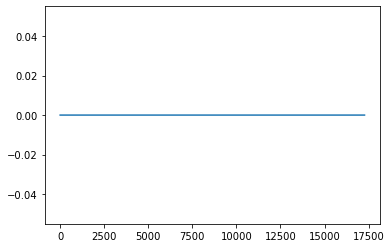

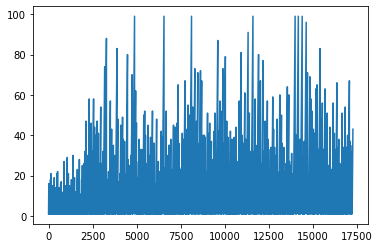

In [8]:
env = gym.make('FrozenLake-v0')
tf.reset_default_graph()

### learning parameters ###
# Goal에 도착할 때까지 몇 번 시도할 것인지
num_episodes = 1000
# discount factor
discount = 0.99
# Exploration을 위한 E-greedy 변수 설정
e = 0.1
# GD를 수행할 learning_rate
learning_rate = 0.1

# 입력 데이터 = 상태 종류 개수로 설정
input_size = env.observation_space.n
# 출력 데이터 = 행동 종류 개수로 설정
output_size = env.action_space.n

# 상태(입력 데이터)가 하나의 상수값인데, 이를 One-hot 형태로 바꿔주기 위한 함수
def one_hot(x):
    input_ohe = np.identity(input_size)[x:x+1]
    return input_ohe

### 데이터 feed 시킬 Placeholder 정의 ###
X = tf.placeholder(tf.float32, shape=[1, input_size])
# 상태(입력 데이터)에 곱해서 행동(출력 데이터)을 도출할 Weight 정의
W = tf.Variable(tf.random_uniform(shape=[input_size, output_size], minval=0, maxval=0.01))
# 액션(출력 데이터) placeholder 정의
Y = tf.placeholder(tf.float32, shape=[1, output_size])

# X,W 내적
Q_pred = tf.matmul(X, W)
# 가장 큰 값을 갖는 index(=가장 큰 값은 갖는 행동) 반한
predict = tf.argmax(Q_pred, axis=1)

### Cost function & GD ###
# Cost 함수는 Sum of square error로 정의
loss = tf.reduce_sum(tf.square(Y - Q_pred))
trainer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

#변수 초기화를 Session 밖에서 정의하기도 함!
init = tf.initialize_all_variables()

### Run Tensors ###
# episode 한 번씩 돌면서 받게 된 보상, Goal에 도달할 때까지의 몇 번 step했는지 담을 list
rList = []
jList = []

with tf.Session() as sess:
    sess.run(init)
    # episode for loop
    for i in range(num_episodes):
        # 초기상태 초기화
        current_state = env.reset()
        Total_reward = 0
        done = False
        j = 0
        
        # 1번의 episode 내에서 Goal에 도달할 때까지 무한 loop(done이 True일 때까지)
        while not done:
            # step 1씩 증가
            j += 1
            
            # episode시작할 때 부여된 random한 초기 state를 feed해서 뉴럴넷을 돌린 후 내뱉은 모든 행동값과 가장 보상이큰 행동값 하나 출력
            a, allQ = sess.run([predict, Q_pred], feed_dict={X: one_hot(current_state)})
            # E-greedy로 Exploration 수행
            if np.random.rand(1) < e:
                # E-greedy 조건 만족시 max Q상관없이 그냥 랜덤하게 행동 취해!
                # array로 반환하기 위해 [0]인덱스 사용한 것!
                a[0] = env.action_space.sample()
            
            # E-greedy 또는 뉴럴넷으로 도출된 가장 높은 보상을 갖는 행동 둘 중 하나로 행동 취하자
            next_state, reward, done, _ = env.step(a[0])
            # 얻은 next_state를 뉴럴렛에 입력해서 도출된 모든 행동 경우 출력
            Qp = sess.run([Q_pred], feed_dict={X: one_hot(next_state)})
            
            # current_state를 뉴럴넷에 입력해서 얻은 모든 행동 경우
            targetQ = allQ
            # current_state에서 얻은 모든 행동 중 가장 보상이 컸던 행동의 '보상값'을..
            # next_state를 뉴럴넷에 넣어 도출된 모든 행동의 보상값들 중 '가장 보상이큰 값'으로 업데이트!
            targetQ[0, a[0]] = reward + discount*np.max(Qp) #---> Q(보상)을 업데이트 해서 Y(label) 생성
            
            _, W1 = sess.run([trainer, W], feed_dict={X: one_hot(current_state),
                                                Y: targetQ}) #---> 뉴럴넷의 Weight를 업데이트
            
            Total_reward += reward
            # state 업데이트
            current_state = next_state
            # Goal에 도달하면 done이 True로 반환됨!
            if done == True:
                # E-greedy 값도 조정
                e = 1.0 / ((i/50) + 10)
                break
            jList.append(j)
            rList.append(Total_reward)

print("Precent of successful episode:"+ str((sum(rList)/num_episodes)*100)+"%")
plt.figure(1)
plt.plot(rList)
plt.figure(2)
plt.plot(jList)
plt.show()

# DQN
- Deep하게 네트워크를 쌓자!(CNN도 사용되기도 함!)
- correlation between samples => ``loop 돌리면서 얻은 state, action, reward를 buffer에 저장하고 random sampling에서 뉴럴넷에 학습 시키기``
- Non-stationary Target(label) => ``Y_pred와 Y_true를 개별적인 네트워크를 사용``
    * 우선 Y_true 네트워크 파라미터를 고정시키고 Y_pred 파라미터를 업데이트
    * 어느정도 주기가 지난 후 업데이트된 Y_pred 파라미터를 복사해서 Y_true 파라미터로 복붙!
    * 그리고 다시 Y_ture 파라미터를 고정시키고 Y_pred 파라미터 업데이트 ...(반복)...

In [10]:
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import random

In [ ]:
EPISODES = 1000

#### DQN Class ####
class DQN_agent:
    # 변수 정의 위해 생성자 함수
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        # buffer에 저장할 memory 정의하기 위해 2000개를 담을 수 있는 비어있는 deque 자료구조 정의
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95 # discount factor
        self.epsilon = 1.0 # for exploration
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001 # 뉴럴넷에서 학습시킬 때 학습률 설정
        # 밑에서 만들어줄 뉴럴넷 모델을 불러오는 함수를 model변수에 할당하기 위해 생성자 함수에 포함시키기
        self.model = self._build_model()
        
    def _build_model(self):
        model = Sequential()
        # input -> 뉴럴넷 유닛개수 24개로 
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        # 뉴럴넷 유닛개수 24개 -> 행동(출력 데이터) 유닛 개수로
        model.add(Dense(self.action_size, activation='linear'))
        # 모델 컴파일 함으로써 Cost function, Optimizer 정의
        model.complie(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model
    
    # 상태, 행동, 보상, Goal에 도착했는지 정보를 Buffer에 저장하는 함수 for experience replay to solve correlations between samples
    def remember(self, state, action, reward, done):
        self.memory.append((state, action, reward, done))
        
    # 다음 상태로 이동하기 위해 행동을 취하는 함수
    def act(self, state):
        # E-greedy for exploration로 얻어낸 행동
        if np.random.rand() <= self.epsilon:
            # 0부터 action_size 범위안의 1 step 시퀀스 안에서 랜덤한 값 하나를 리턴
            return random.randrange(self.action_size)
        
        # 뉴럴넷으로 얻어낸 행동들 중 가장 max 보상을 갖는 행동
        act_values = self.model.predict(state)
        return np.argmax(act_values[0]) # [0]은 array로 반환하기 위해!
    
    # Experience Replay 수행하는 함수
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            # done이 False로 나왔을 때, 즉 아직 Goal에 도달하지 못한 경우 Y label 업데이트 -> ??
            if not done:
                target = (reward + self.gamma*np.amax(self.model.predict(state)[0]))
            
            
            